## <div style="text-align: center"> First Impression about Deepfake Detection Challenge

</div>
<img src="http://www.unidiversidad.com.ar/cache_2/deepfakevide_630_945.jpg">

Deepfake techniques, which present realistic AI-generated videos of people doing and saying fictional things, have the potential to have a significant impact on how people determine the legitimacy of information presented online. These content generation and modification technologies may affect the quality of public discourse and the safeguarding of human rights—especially given that deepfakes may be used maliciously as a source of misinformation, manipulation, harassment, and persuasion. Identifying manipulated media is a technically demanding and rapidly evolving challenge that requires collaborations across the entire tech industry and beyond.


<a id="top"></a> <br>
## Notebook  Content

1. [Import](#1)
1. [Load Data](#2)
1. [Display images](#3)
1. [TAke some frames](#4)
1. [Face Detection](#5)
1. [Region Of interest](#6)
1. [Example of Submission](#7)



**<a id="1"></a> <br>**
## 1- Import

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

**<a id="2"></a> <br>**
## 2- Load Data

In [2]:


train_dir = '/kaggle/input/deepfake-detection-challenge/train_sample_videos/'
train_video_files = [train_dir + x for x in os.listdir(train_dir)]
test_dir = '/kaggle/input/deepfake-detection-challenge/test_videos/'
test_video_files = [test_dir + x for x in os.listdir(test_dir)]



In [3]:
df_train = pd.read_json('/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json').transpose()
df_train.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [4]:
df_train.shape # We have 400 videos 

(400, 3)

In [5]:
df_train.original.nunique()  # from this aprox 209 originals create 400, would be the same video? lest check soon

209

In [6]:
df_train.label.value_counts()

FAKE    323
REAL     77
Name: label, dtype: int64

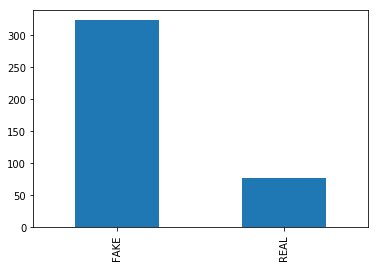

In [7]:
df_train.label.value_counts().plot.bar()

In [8]:
df_train.label.value_counts(normalize=True) # Check that aprox 80% are fake

FAKE    0.8075
REAL    0.1925
Name: label, dtype: float64

In [9]:
df_train['original'].value_counts()

meawmsgiti.mp4    6
atvmxvwyns.mp4    6
kgbkktcjxf.mp4    5
qeumxirsme.mp4    5
fysyrqfguw.mp4    4
                 ..
kdodrvufdh.mp4    1
edyncaijwx.mp4    1
wwqiuiwdbz.mp4    1
jszyyhamrh.mp4    1
yoavqsqobz.mp4    1
Name: original, Length: 209, dtype: int64

In [10]:
df_train[df_train['original']=='meawmsgiti.mp4']  # Looking the same files of videos

,label,split,original
akxoopqjqz.mp4,FAKE,train,meawmsgiti.mp4
altziddtxi.mp4,FAKE,train,meawmsgiti.mp4
arlmiizoob.mp4,FAKE,train,meawmsgiti.mp4
axczxisdtb.mp4,FAKE,train,meawmsgiti.mp4
bqhtpqmmqp.mp4,FAKE,train,meawmsgiti.mp4
czkdanyadc.mp4,FAKE,train,meawmsgiti.mp4


In [11]:
video1= train_dir + 'akxoopqjqz.mp4'  
video2 =train_dir + 'altziddtxi.mp4'
video3 = train_dir+ 'arlmiizoob.mp4'

**<a id="3"></a> <br>**
## 3- Display Images

In [12]:
def display_img(video):
    cap = cv2.VideoCapture(video)  # take 1 picture
    ret, frame = cap.read()
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

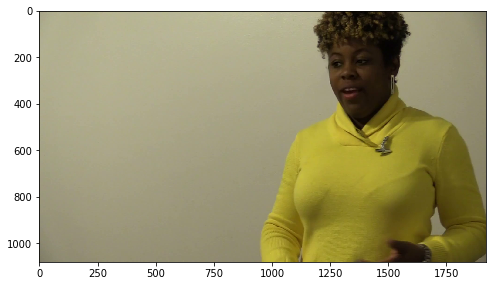

In [13]:
display_img(video1)

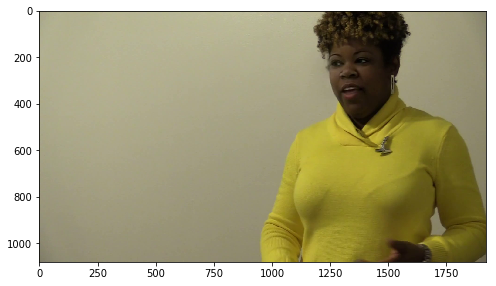

In [14]:
display_img(video2)


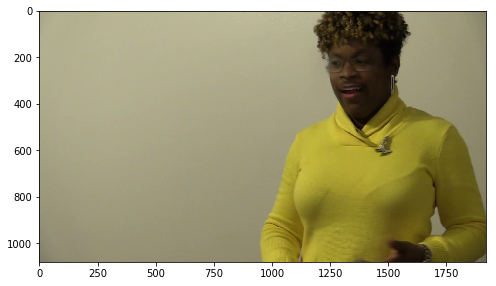

In [15]:
display_img(video3)  # lets check this picture 

# Start working with simple video

In [16]:
first_Video = train_video_files[8]
first_Video

'/kaggle/input/deepfake-detection-challenge/train_sample_videos/eukvucdetx.mp4'

In [17]:
name_video = first_Video.split('/', 5)[5] # I will use this funtion soon

In [18]:
df_train[df_train.index == name_video] 

,label,split,original
eukvucdetx.mp4,FAKE,train,gjypopglvi.mp4


**<a id="4"></a> <br>**
## 4- take some Frames

In [19]:
count = 0
cap = cv2.VideoCapture(first_Video)
ret,frame = cap.read()

while count < 3:
    cap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))   
    ret,frame = cap.read()
    if count == 0:
        image0 = frame
    elif count == 1:
        image1 = frame
    elif count == 2:
        image2 = frame
    
    #cv2.imwrite( filepath+ "\frame%d.jpg" % count, image)     # Next I will save frame as JPEG
    count = count + 1

In [20]:
def display(img):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)

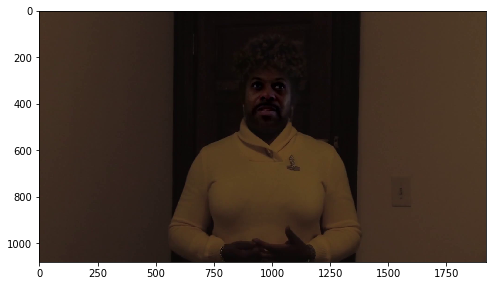

In [21]:
display(image0)  # frame 1

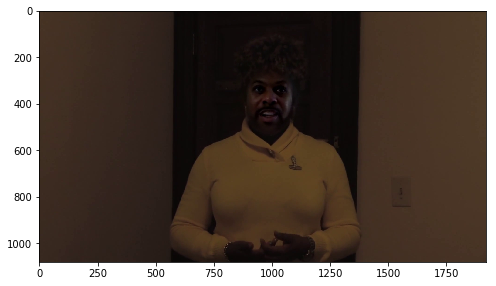

In [22]:
display(image1) # frame 2

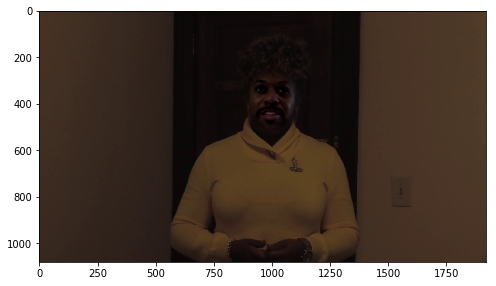

In [23]:
display(image2) # frame 3

**<a id="5"></a> <br>**
## 5- Face Detection

In [24]:
# You need to Download or add this file to your notebook, Check in the input files

face_cascade = cv2.CascadeClassifier('/kaggle/input/cascade/haarcascade_frontalface_default.xml' ) # Cascade for faces

In [25]:
def detect_face(img):
    
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img,scaleFactor=1.3, minNeighbors=5) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (0,255,0), 10) 
        
    return face_img

In [26]:
result = detect_face(image2)

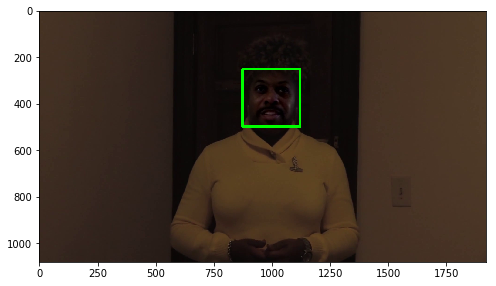

In [27]:
display(result)

In [28]:
second_Video= train_video_files[10]


In [29]:
name_video2 = second_Video.split('/', 5)[5] # I will use this funtion soon
name_video2

'cwsbspfzck.mp4'

In [30]:
df_train[df_train.index == name_video2] 

,label,split,original
cwsbspfzck.mp4,FAKE,train,wtreibcmgm.mp4


In [31]:

count = 0
cap = cv2.VideoCapture(second_Video)
ret,frame = cap.read()

while count < 5:
    cap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))   
    ret,frame = cap.read()
    if count == 0:
        image0 = frame
    elif count == 1:
        image1 = frame
    elif count == 2:
        image2 = frame
    elif count == 3:
        image3 = frame
    elif count == 4:
        image4 = frame
    
    #cv2.imwrite( pathOut + "\\frame%d.jpg" % count, image)     # Next I will save frame as JPEG
    count = count + 1

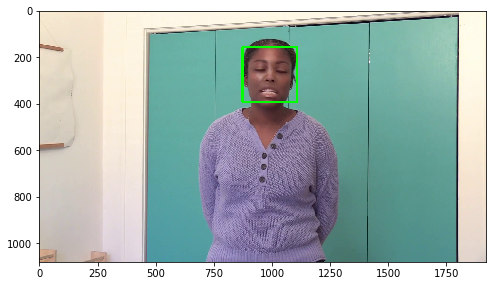

In [32]:
image = detect_face(image0)
display(image)

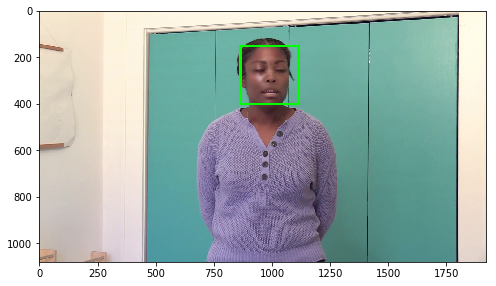

In [33]:
image = detect_face(image2)
display(image)

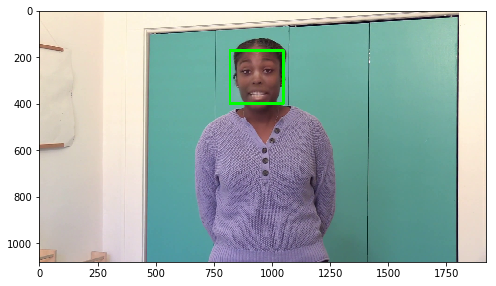

In [34]:
image = detect_face(image3)
display(image)

**<a id="6"></a> <br>**
## 6- Create a Region of Interest (ROI)*

<div class="alert alert-success">  Lets Check the region of interest

</div>

In [35]:
def ROI(img):
    
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img,scaleFactor=1.3, minNeighbors=5) 
    
    for (x,y,w,h) in face_rects: 
        roi = face_img[y:y+h,x:x+w] 
        
        
    return roi

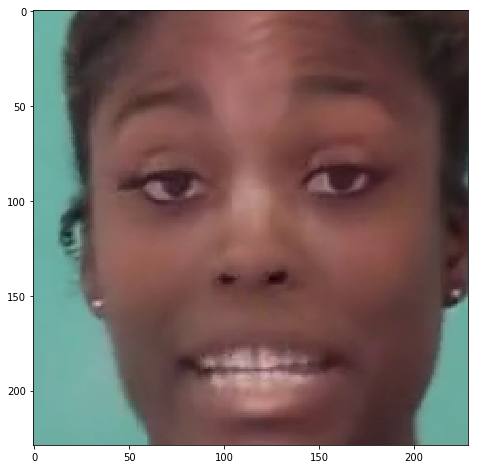

In [36]:
image = ROI(image3)
display(image)

## Expand Region of interest

In [37]:
def ROI_Expand(img):
    
    offset = 50  # play around this value
    
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img,scaleFactor=1.3, minNeighbors=5) 
    
    for (x,y,w,h) in face_rects: 
        roi = face_img[y-offset:y+h+offset,x-offset:x+w+offset] 
        
        
    return roi

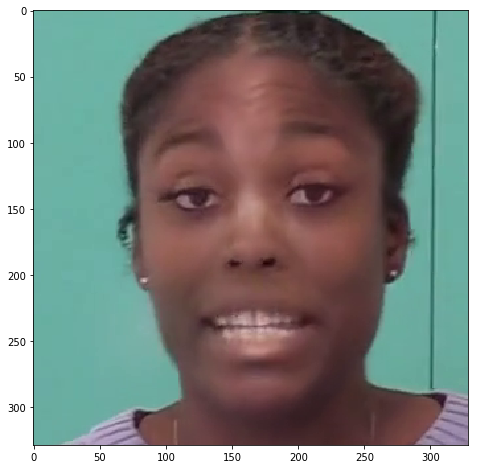

In [38]:
image = ROI_Expand(image3)
display(image)

**<a id="7"></a> <br>**
## 7- Example of Submission*

In [39]:
submission = pd.read_csv("/kaggle/input/deepfake-detection-challenge/sample_submission.csv")
submission['label'] = 0.5 # 
submission.to_csv('submission.csv', index=False)

## I hope this notebook **helpfull** for you

